Epoch 1/20 - Val Accuracy: 0.9471
Epoch 2/20 - Val Accuracy: 0.9505
Epoch 3/20 - Val Accuracy: 0.9388
Epoch 4/20 - Val Accuracy: 0.9544
Epoch 5/20 - Val Accuracy: 0.9519
Epoch 6/20 - Val Accuracy: 0.9515
Epoch 7/20 - Val Accuracy: 0.9553
Epoch 8/20 - Val Accuracy: 0.9578
Epoch 9/20 - Val Accuracy: 0.9553
Epoch 10/20 - Val Accuracy: 0.9583
Epoch 11/20 - Val Accuracy: 0.9529
Epoch 12/20 - Val Accuracy: 0.9597
Epoch 13/20 - Val Accuracy: 0.9660
Epoch 14/20 - Val Accuracy: 0.9699
Epoch 15/20 - Val Accuracy: 0.9782
Epoch 16/20 - Val Accuracy: 0.9801
Epoch 17/20 - Val Accuracy: 0.9854
Epoch 18/20 - Val Accuracy: 0.9743
Epoch 19/20 - Val Accuracy: 0.9816
Epoch 20/20 - Val Accuracy: 0.9854
✅ Test Accuracy: 0.991856124872752
✅ Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       496
           1     1.0000    1.0000    1.0000       471
           2     1.0000    1.0000    1.0000       420
           3     0.9854    0.96

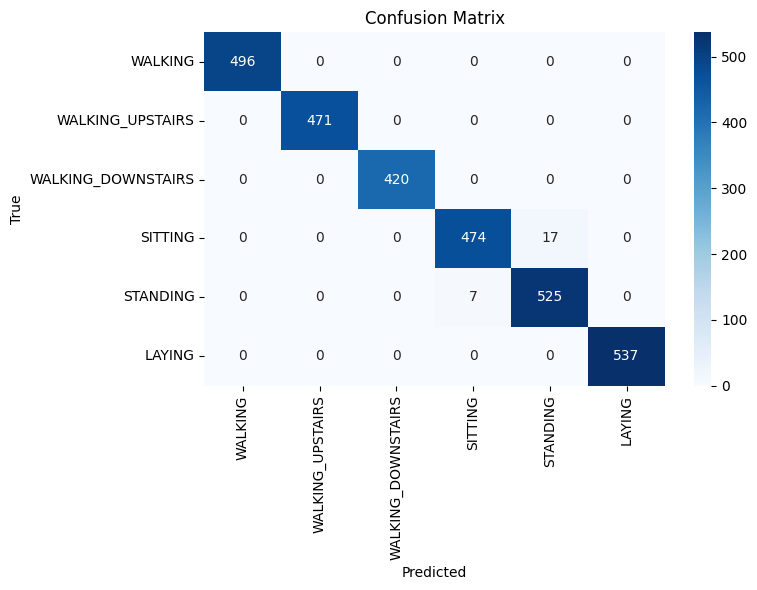

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------
# 1. Dataset & Loader
# ----------------------------------
class UCIHAR_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def load_ucihar_raw(base_path):
    INPUT_FILES = [
        "total_acc_x_", "total_acc_y_", "total_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
        "body_acc_x_", "body_acc_y_", "body_acc_z_"
    ]

    def load_group(files, subset):
        data = []
        signal_path = os.path.join(base_path, subset, "Inertial Signals")
        for file in files:
            full_path = os.path.join(signal_path, file + subset + ".txt")
            data.append(np.loadtxt(full_path))
        X = np.stack(data, axis=1)
        return X

    X_train = load_group(INPUT_FILES, "train")
    X_test = load_group(INPUT_FILES, "test")

    y_train = np.loadtxt(os.path.join(base_path, "train", "y_train.txt")) - 1
    y_test = np.loadtxt(os.path.join(base_path, "test", "y_test.txt")) - 1

    return X_train, y_train, X_test, y_test

def preprocess(X_train, X_test):
    N, C, T = X_train.shape
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(N, -1)).reshape(N, C, T)
    X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape[0], C, T)
    return X_train, X_test

# ----------------------------------
# 2. 모델 구성
# ----------------------------------
class CBAMBlock1D(nn.Module):
    def __init__(self, channels, reduction=4, kernel_size=7):
        super().__init__()
        self.pool_avg = nn.AdaptiveAvgPool1d(1)
        self.pool_max = nn.AdaptiveMaxPool1d(1)
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid_channel = nn.Sigmoid()
        self.conv_spatial = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        b, c, t = x.size()
        avg_out = self.mlp(self.pool_avg(x).view(b, c))
        max_out = self.mlp(self.pool_max(x).view(b, c))
        scale = self.sigmoid_channel(avg_out + max_out).view(b, c, 1)
        x = x * scale

        avg_spatial = torch.mean(x, dim=1, keepdim=True)
        max_spatial, _ = torch.max(x, dim=1, keepdim=True)
        spatial = torch.cat([avg_spatial, max_spatial], dim=1)
        spatial = self.sigmoid_spatial(self.conv_spatial(spatial))
        x = x * spatial
        return x

class LightMambaBlock1D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.proj_in = nn.Linear(dim, dim)
        self.dw_conv = nn.Conv1d(dim, dim, kernel_size=3, padding=1, groups=dim)
        self.gate = nn.Sigmoid()
        self.proj_out = nn.Linear(dim, dim)

    def forward(self, x):
        x = self.norm(x)
        x_proj = self.proj_in(x)
        x_conv = self.dw_conv(x_proj.transpose(1, 2)).transpose(1, 2)
        x = self.proj_out(x_conv * self.gate(x_proj))
        return x

class ContextAwarePrototypeModule(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.feature_dim = feature_dim
        self.prototypes = nn.Parameter(torch.randn(num_classes, feature_dim))
        self.query_proj = nn.Linear(feature_dim, feature_dim)

    def forward(self, x):
        B = x.size(0)
        q = self.query_proj(x)
        p = self.prototypes.unsqueeze(0).expand(B, -1, -1)
        modulated_proto = p + q.unsqueeze(1)
        x_norm = F.normalize(x, dim=1)
        p_norm = F.normalize(modulated_proto, dim=2)
        logits = torch.bmm(p_norm, x_norm.unsqueeze(2)).squeeze(2)
        return logits

class CBAM_Mamba_HAR(nn.Module):
    def __init__(self, in_channels, num_classes, patch_size=8, hidden_dim=128, num_mamba_blocks=4):
        super().__init__()
        self.attn = CBAMBlock1D(in_channels)
        self.patch_size = patch_size
        self.token_dim = in_channels * patch_size

        self.down_proj = nn.Conv1d(self.token_dim, hidden_dim, kernel_size=1)
        self.mamba_blocks = nn.ModuleList([LightMambaBlock1D(hidden_dim) for _ in range(num_mamba_blocks)])
        self.up_proj = nn.Conv1d(hidden_dim, self.token_dim, kernel_size=1)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = ContextAwarePrototypeModule(feature_dim=in_channels, num_classes=num_classes)

    def forward(self, x):
        b, c, t = x.size()
        assert t % self.patch_size == 0, "T must be divisible by patch_size"

        x = self.attn(x)
        x = x.view(b, c, t // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 1, 3).reshape(b, t // self.patch_size, -1)

        x = self.down_proj(x.transpose(1, 2)).transpose(1, 2)
        for block in self.mamba_blocks:
            x = block(x) + x
        x = self.up_proj(x.transpose(1, 2)).transpose(1, 2)

        x = x.view(b, t // self.patch_size, c, self.patch_size).permute(0, 2, 1, 3)
        x = x.reshape(b, c, t)
        x = self.global_pool(x).squeeze(-1)
        return self.classifier(x)

# ----------------------------------
# 3. 학습 및 평가 루프
# ----------------------------------
def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}/{epochs} - Val Accuracy: {acc:.4f}")

def evaluate_model(model, test_loader, class_names=None):
    device = next(model.parameters()).device
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print("✅ Test Accuracy:", acc)
    print("✅ Classification Report:\n", classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else range(cm.shape[0]),
                yticklabels=class_names if class_names else range(cm.shape[0]))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# ----------------------------------
# 4. 실행
# ----------------------------------
if __name__ == "__main__":
    base_path = "/content/drive/MyDrive/Colab Notebooks/UCI-HAR/UCI-HAR"
    X_train, y_train, X_test, y_test = load_ucihar_raw(base_path)
    X_train, X_test = preprocess(X_train, X_test)

    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])

    X_tr, X_val, y_tr, y_val = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

    train_loader = DataLoader(UCIHAR_Dataset(X_tr, y_tr), batch_size=64, shuffle=True)
    val_loader = DataLoader(UCIHAR_Dataset(X_val, y_val), batch_size=64)
    test_loader = DataLoader(UCIHAR_Dataset(X_test, y_test), batch_size=64)

    model = CBAM_Mamba_HAR(in_channels=9, num_classes=6)
    train_model(model, train_loader, val_loader, epochs=20)

    class_names = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS",
                   "SITTING", "STANDING", "LAYING"]
    evaluate_model(model, test_loader, class_names=class_names)

